# Stokes flow and numerical Stokes sinker experiment

## Equations for the Stokes problem - Background as to what is going on

For background, here are the general and the specific equations we are solving in this exercise. The general force balance equation for a continuum says that gradients in stress $\sigma$ can be balanced by accelerations and body forces, 
$$
\begin{align}
  \rho \frac{Du}{Dt} = \nabla \cdot \sigma + f = \nabla \cdot \sigma + \rho g,
\end{align}
$$
where $\rho$ is density, $u$ velocity, $f$ a body force, and $g$ acceleration due to body forces.
The left hand side (LHS) is about acceleration, and has a material time derivative which can include advective transport. 
$$
\frac{Dx}{Dt} = \frac{\partial x}{\partial t} + (v \nabla) x.
$$
A balance between the LHS and the stress gradient balances wave propagation, for example. 
This equation holds for dynamic equilibrium for any material, and if we use a compressible Newtonian fluid, the consititutive relation allowing for shear, $\eta$, and bulk viscosity, $\kappa$, is.
$$
\sigma = -p I + \eta(\nabla v + (\nabla v)^T) + (\kappa -\frac{2}{3}\eta)(\nabla \cdot v) I
$$
The Navier-Stokes momentum equation results from plugging in the constitutive law into the dynamic force balance 
$$
  \rho \frac{Du}{Dt} = - \nabla [p-\zeta (\nabla \cdot u)] + \nabla \cdot \left\{ \mu [\nabla u + (\nabla u)^T - \frac{2}{3}(\nabla \cdot u) I)] \right\} + \rho g.
$$
This equation is quite complicated in incompletely understood, it is also very difficult to solve, even with a computer, and highly nonlinear. 

As we discussed, the mantle's viscosity is so high that the Reynold's number which measures turbulence and the effects of inertia is zero. This means that the LHS of the force balance is zero
$$
\begin{align}
   \nabla \cdot \sigma + \rho g = 0,
\end{align}
$$
which says that any gradients in stress or strain for static force balance are due to the body forces, here buoyancy forces. This also means that for given boundary conditions, density distributions, and material behavior, any deformation state will adjust *instantaneously*.


If we also assume the fluid is incompressible, $\nabla \cdot v=0$, then the constitutive law for Newtonian flow is
$$
\sigma = -p I + \eta(\nabla v + (\nabla v)^T) 
$$
where the $\nabla v + (\nabla v)^T$ term is another way to write the strain-rate tensor $2\dot{\epsilon}$, and the version of this constitutive law we want you to recognize is for the deviatioric component of the stress tensor $\tau = \sigma +pI$,
$$
\begin{align}
\tau = 2 \mu \dot{\epsilon}
\end{align}
$$

If the inertia term is ignored and the fluid is incompressive like that, the Navier Stokes equation turns into the *Stokes equation* which reads 
$$
\begin{align}
  - \nabla p + \nabla \cdot \left\{ \mu [\nabla u  + {\nabla u}^T] \right\} + \rho g = 0. 
\end{align}
$$
*This* is what we are solving in this exercise and it says that the gradients in dynamic pressure as well as viscous dissipation as reflected in the gradients in velocities are balanced by body forces.


The solution is performed by finite elements using the FEniCSx package. Again for background, in solving the FEniCSx system, the sign of pressure is changed from the traditional definition in the above equations. The purpose is to generate a symmetric system of equations. When plotting the pressure, we change the sign back.

Here are the equations for the Stokes problem, assuming $\mu=1$, 
$$
\begin{align}
  - \nabla \cdot (\nabla u + p I) &= \rho g \quad {\rm in} \ \Omega,\\
  \nabla \cdot u &= 0 \quad {\rm in} \ \Omega.
\end{align}
$$

with conditions on the boundary $\partial \Omega = \Gamma_{D} \cup
\Gamma_{N}$ of the form:

$$
\begin{align}
  u &= u_0 \quad {\rm on} \ \Gamma_{D},\\
  \nabla u \cdot n + p n &= g \,   \quad\;\; {\rm on} \ \Gamma_{N}.
\end{align}
$$

## Short version to read for sure

We are solving the instantaneous Stokes flow problem for pressure and velocities in an incompressible, laminar fluid. The constitutive law for the deviatoric stress is $\tau = 2\eta \dot{\epsilon}$ and the equation describing motion is 
$$
\begin{align}
  - \nabla p + \nabla \cdot \left\{ \mu [\nabla u  + {\nabla u}^T] \right\} + \rho g = 0, 
\end{align}
$$
where $p$ is dynamic pressure, $u$ velicity, $\nabla$ the gradient operator, $\rho$ density, and $g$ gravitational acceleration, and $[\nabla u  + {\nabla u}^T] =2\dot{\epsilon}$ the strain-rate tensor.


Let's load the packages

In [1]:
# loading packages
import numpy as np
import ufl
from dolfinx.fem import (Constant, Function, FunctionSpace, dirichletbc,
                         extract_function_spaces, form,
                         locate_dofs_topological, locate_dofs_geometrical)
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from mpi4py import MPI
from petsc4py import PETSc
from ufl import div, dx, grad, inner
from dolfinx import fem, la
from dolfinx.io import gmshio
from math import *
from dataclasses import dataclass,astuple,asdict # for C-like structure

from StokesLib import gmsh_stokes_tutorial, fem_main, block_iterative_solver, describeModel, runScenarioPlot
import pyvista
from dolfinx import plot

import warnings
warnings.filterwarnings("ignore")

Everything in the model computation you will need to change is defined in this parameter class, see the sketch below.

In [2]:
# model description: a top rectangle + a bottom rectangle + an elliptical inclusion inside the bottom rectangle.
# ---
# boundary descriptions:
# left boundary  : A
# bottom boundary: B
# right boundary : C
# top boundary   : D
# ---
# material properties:
@dataclass
class parameters: 
    # Adjustable parameters
    eta_crust = 1.  # viscosity of the upper block.
    eta_mantle = 1.  # viscosity of the bottom block.
    eta_inc = 1000.  # viscosity of the elliptical anomaly. 

    dgrav = 500. # delta gravity anomaly for the ellipse. 

    # ----------------------------------
    # adjustable parameters for the mesh.
    dxx = 0.1 # cell size near boundary points.

    w = 1.  # width of the model
    h_mantle = 0.8  # height of the bottom rectangle
    h_crust = 0.2 # heigth of the top rectangle

    xe = 0.5;  # x cooridnate of the ellipse center
    ye = 0.5; # y coordinate of the ellipse center
    # the center of the ellipse is at the center of the bottom rectangle at (xe,ye)=(w/2,h1/2).
    ra = 0.1 # a of the ellipse
    rb = 0.1 
    
    rot = 0.5*pi # rotation of the ellipse counterclockwise around its center in radians.

    bcs_type  = 1   # please choose the boundary conditions and the options could be expanded. 
    # 1: free slip for all surfaces A-D;
    # 2: free slip for A-C, D free.
    # 3: no slip for all A-D.
    # 4: no slip for B, fixed velocity for D, no y motion + tao_xy=0 for A and C. 

This figure shows the model setup.
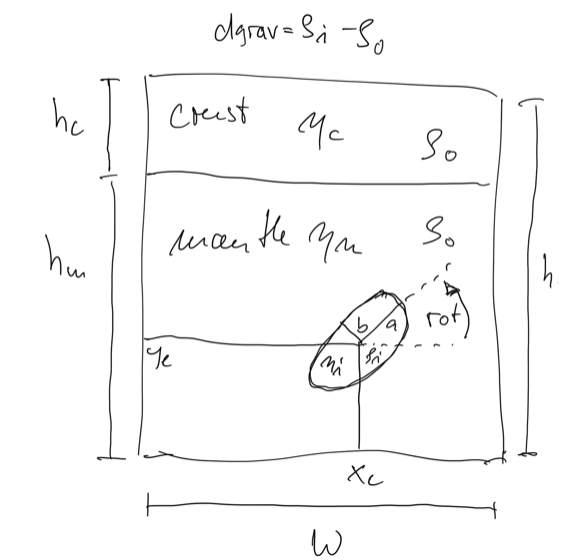

This figure shows the four types of boundary conditions supported. They can be assigned via parameter bcs_type = 1 (2/3/4). 
The triangle with the little wheels means motion can be stress free the direction the wheels roll, and is prohibited perpendicular to it (*free slip*). If there's wiggles underneath, this is to mean fixed in all directions (*no slip*). BC 2 has a free surface, as was discussed for the Earth's dynamic topography. Case 4 is for a shearing experiment, which you can try, but we will not use it here.

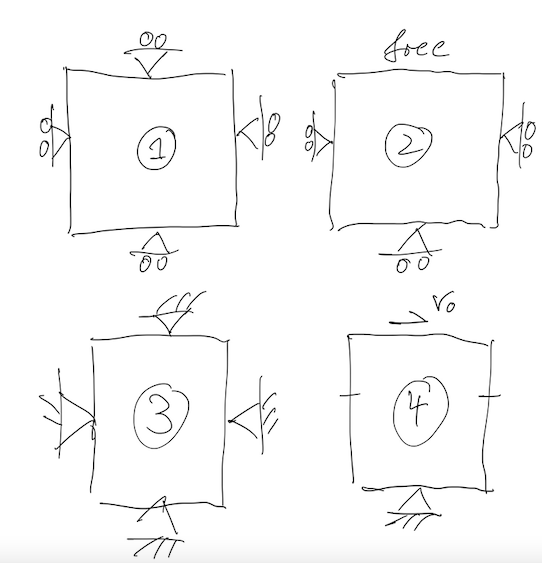

## Experiment 1: Reference model for a high viscosity spheric anomaly in the mantle.

Note: To change parameters, load a parameters class, and then change them, as shown below, and referencing the explanation above.

Model description: 
The model domain is 1 X 1 (w X [h_crust + h_mantle]). The thicknesses of two layers - crust (h_crust) and mantle (h_mantle)- could be assigned, but in this model, wo don't differentiate them. 

There is a spheric anomaly that has a radius of 0.1 (ra and rb for the half major and minor axes of an ellipitical anomaly; set ra = rb = 0.1 for this spheric case) and higher viscosity of 1000 (eta_inc) compared to 1 of the surroundings (eta_crust and eta_mantle).

The x and y coordinantes of the center of the anomaly are xe and ye.  

The density are homogeneous. 
The boundary conditions are free slip, i.e., no flow normal to the boundaries (bcs_type = 1). 

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  1000.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
No normalization is needed.
No normalization is needed.
No normalization is needed.


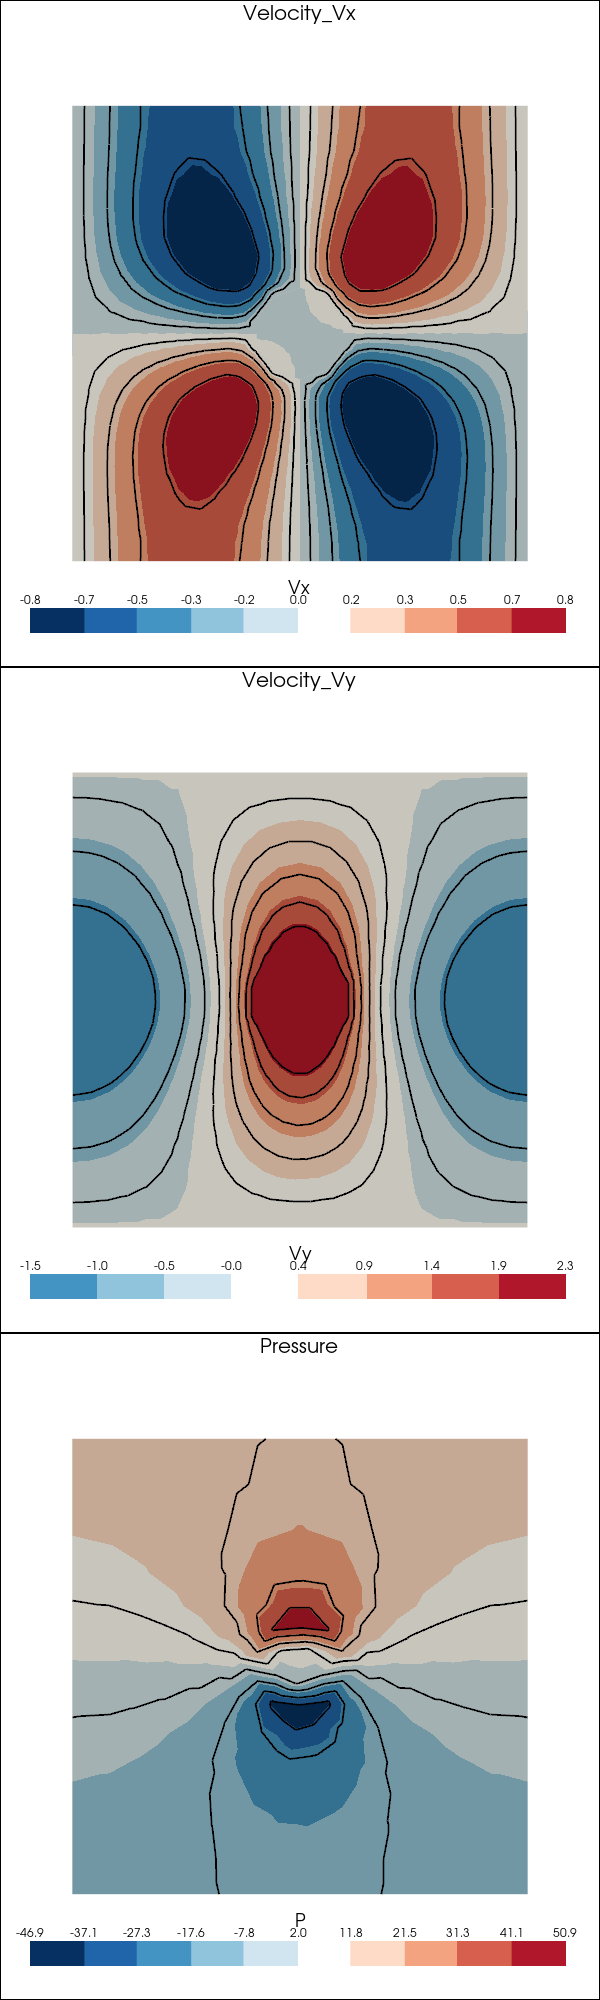

In [3]:
par = parameters()
#par.w, par.h_mantle, par.h_crust = 1, 0.8, 0.2
#par.xe, par.ye = 0.5, 0.5
#par.ra, par.rb = 0.1, 0.1
par.eta_inc = 1000.
#par.eta_mantle, par.eta_crust = 1., 1.
par.dgrav = 1000.
par.bcs_type = 1
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

These graphs represent the movement of the sphere as well as the liquid around the ball through colors and measurments.

Velovity Vx: we find the velocity in correlation with the x axis. From this we find that with the original parameters, the liquid around the ball will first move outwards at the top of the ball, and inwards as it fully moves past the ball. 

Velocity Vy: we find the correlation between velocity and the y axis. From this we find that as the ball is moving up, the surrounding liquid will have a negative velocity and moving downward. We see this because the red represents positive velocity on the y axis, which is up, and negative velocity on the outsides represented by blue that means it will go down.

Pressure: In this graph we find that the pressure as the ball is moving up is more compressed and at the bottom of the ball the pressure is weaker. We see this through the red and the blue colors correlating with the magnitude of pressure. As the ball tries to move up the pressure will increase as it moves through the liquid. In real life mantle plume examples, depending on how strong this is, there can be uplift at the earth's surface. 


Run the same model but show velocities as vectors with mesh. 

Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
No normalization is needed.
No normalization is needed.
No normalization is needed.


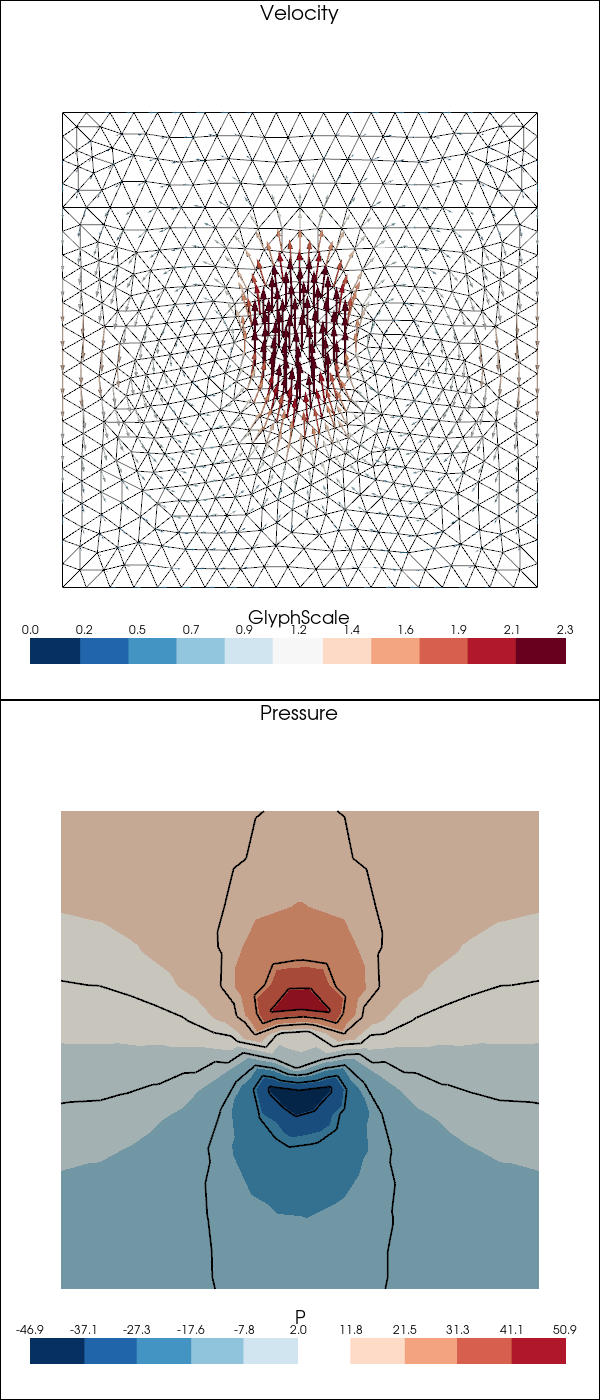

In [4]:
runScenarioPlot(par, plotStyle='vector')

The first graph is a more intricate version of the previous velocity graphs, it shows the arrows representing the motion of the ball and the surroundings. this is the only difference between the these graphs and the previous ones, the rest of the imformation is fairly the same and does not necessarily change. 

## Experimental series 2: What numerical resolutions should we use?
Grid size can be adjusted by changing dxx, whose default is 0.1.
What if you decrease dxx? 

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  500.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 3954 nodes
Info    : 7906 elements
Info    : Done reading 'stokes.msh'
No normalization is needed.
No normalization is needed.
No normalization is needed.


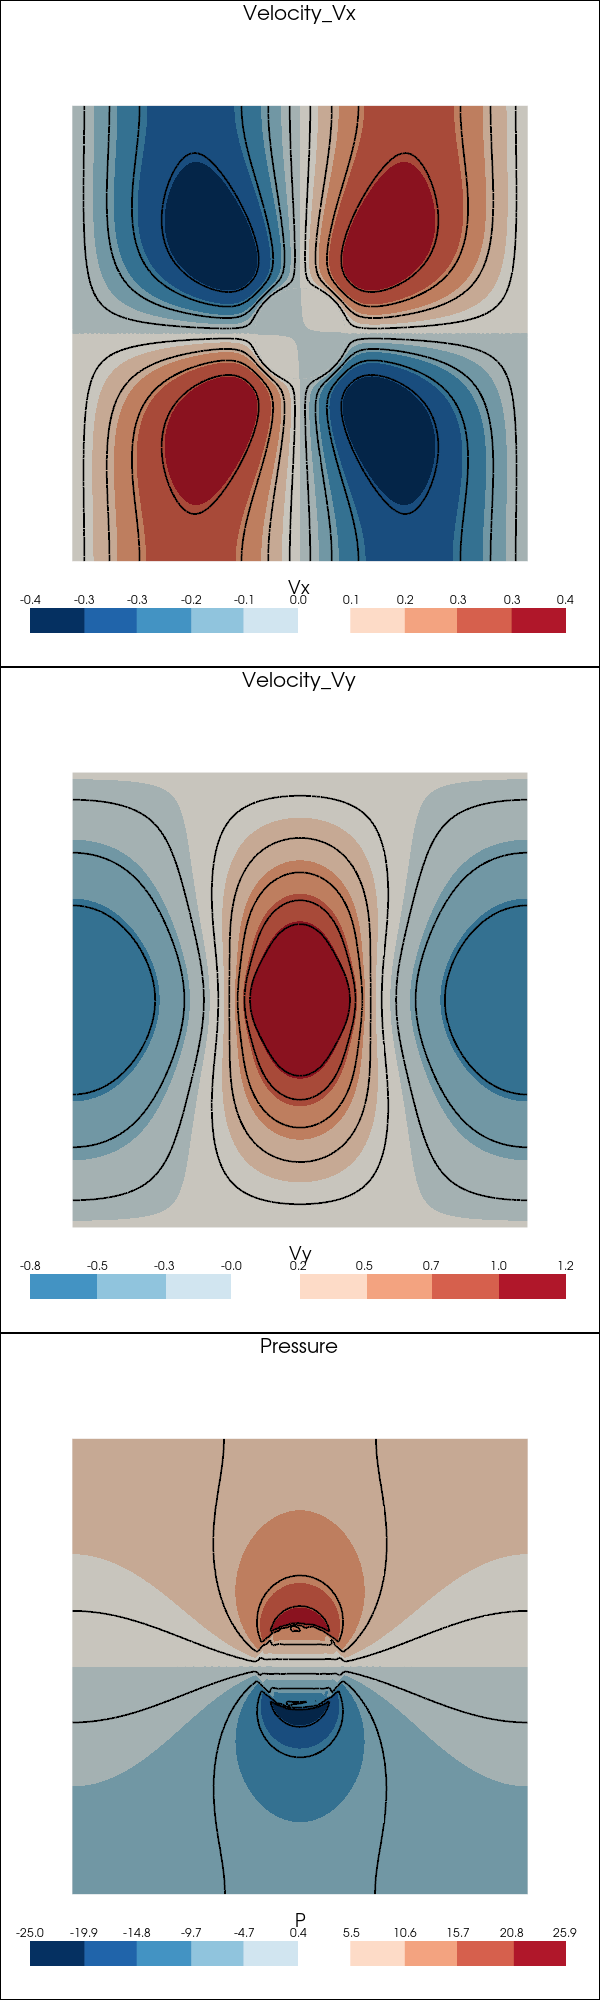

Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 3954 nodes
Info    : 7906 elements
Info    : Done reading 'stokes.msh'
No normalization is needed.
No normalization is needed.
No normalization is needed.


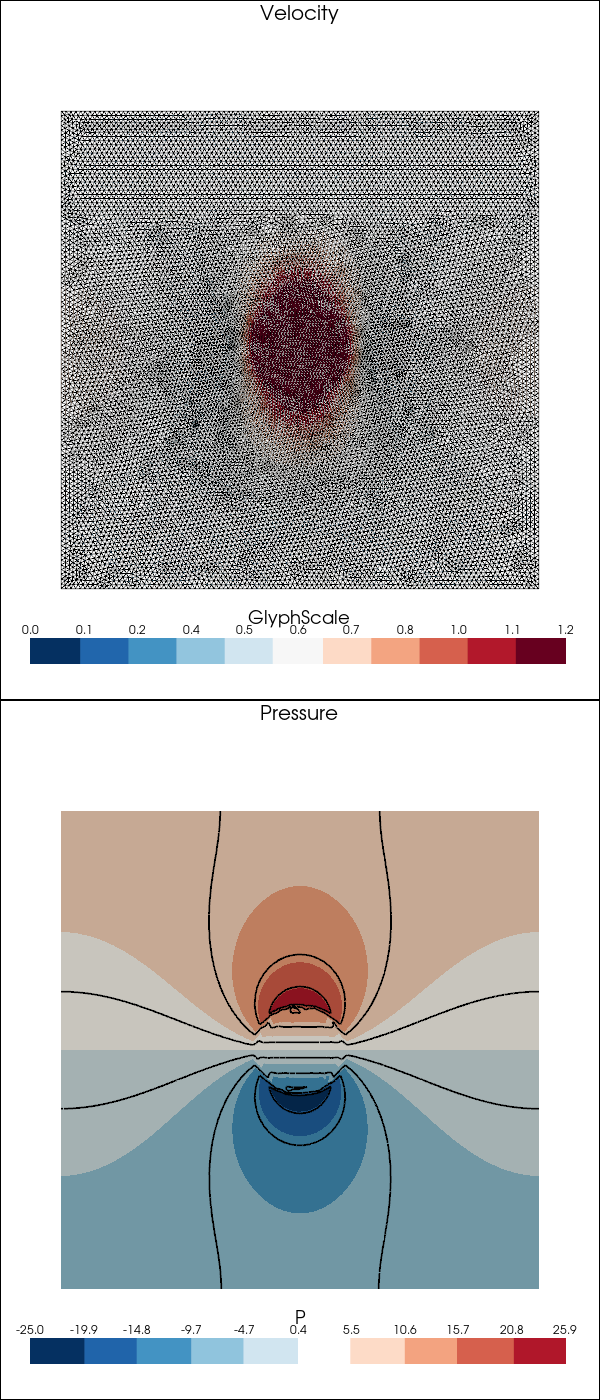

In [6]:
par = parameters()
par.dxx = 0.02
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')
runScenarioPlot(par, plotStyle='vector')

Whenever we increase the resolution of our vector graph, we see that it becomes more difficult to visibly see what is occuring in the experiment, in the previous resolution, we could clearly see the motion of the arrows representing the velocity. The overall results are similar to the same, but the way the information is presented is shown differently. 

Velocity chosen: 1.2 (the middle of the sphere in the Vy graph)
Resolution Chosen: For my resolution I wanted my data to be more accurate so I chose a lower resolution. I think that the accuracy improves because we see more closely into the velocity and with less varied velocity results. 
par.dxx = 0.01

## Experiment 3: the effect of boundary conditions. 

First, let's examine the velocities and pressures for the best solution. 

What patterns do you observe, for example, where is velocity/pressure highest and lowest? 

What if we change the boundary condition of the top to free surface? (bcs_type = 2)

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  500.0
Boundary conditions are  free slip for lateral sides and bottom, but the top is free.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
No normalization is needed.
No normalization is needed.
No normalization is needed.


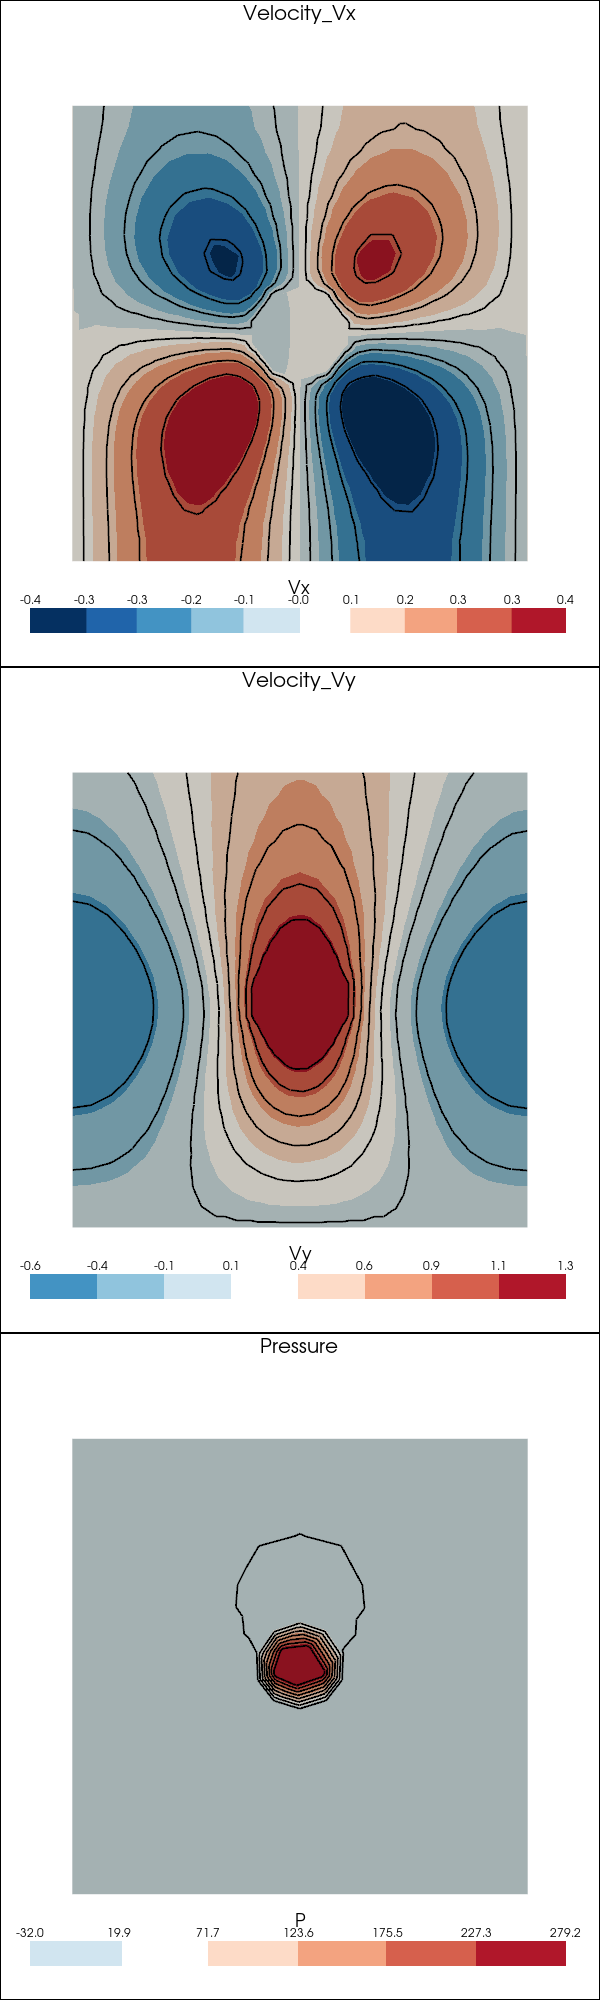

In [7]:
par = parameters()
par.bcs_type = 2
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

Whenever we use bcs_type = 2: 

Vx: We find that the velocity at the top of the ball is generally slower than at the bottom of the ball where the velocity increases. Throught this I can infer that at the speed of the ball is slower as it moves up and as the liquid mves around the bottom, it increases velocity.

Vy: In this graph we find that our sphere velocity on the y axis increases all the way to the top of the plot. This means that in a real world situation, there will most likely be uplift because of the consistent movement upwards to the top of the surface. 

Pressure: From what we see in the graph, there is no compressive pressure at the top of the graph compared to bcs 1. We see this becasue there is nothing blocking the top of the ball so it can move freely, because of this there is nowhere for the pressure to accumilate. 

for geological problems such as mantle plumes or subduction zones, the best bcs type to use would probably be bcs 2 because of the way it moves. If we have a mantle plume for example, there will be free movement upward causing things such a uplift as it moves closer to the surface and the pressure increases. We also see that if we change the bcs types we can break the symmetry because you allow it to flow more freely. 

And what if we change the boundary conditions to no slip, i.e., zero velocities on all the boundaries. (bcs_type = 3) 

In [ ]:
par = parameters()
par.bcs_type = 3
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

## Experiment 4: Scaling tests

### 4a: Verify and determine the scaling relationship between velocities and density anomaly and background viscosity

Let's go back to the default setup with free slip boundaries and use a strong sphere.

Could you verify that the velocities scale with density anomaly/viscosity? 
1. Please run models with different $\Delta\rho g$ (dgrav) and record how maximum velocity and plot the relationship between the maximum velocity and $\Delta\rho g$.
2. Please do the same experiments for different viscosities. 

Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
No normalization is needed.
No normalization is needed.
No normalization is needed.


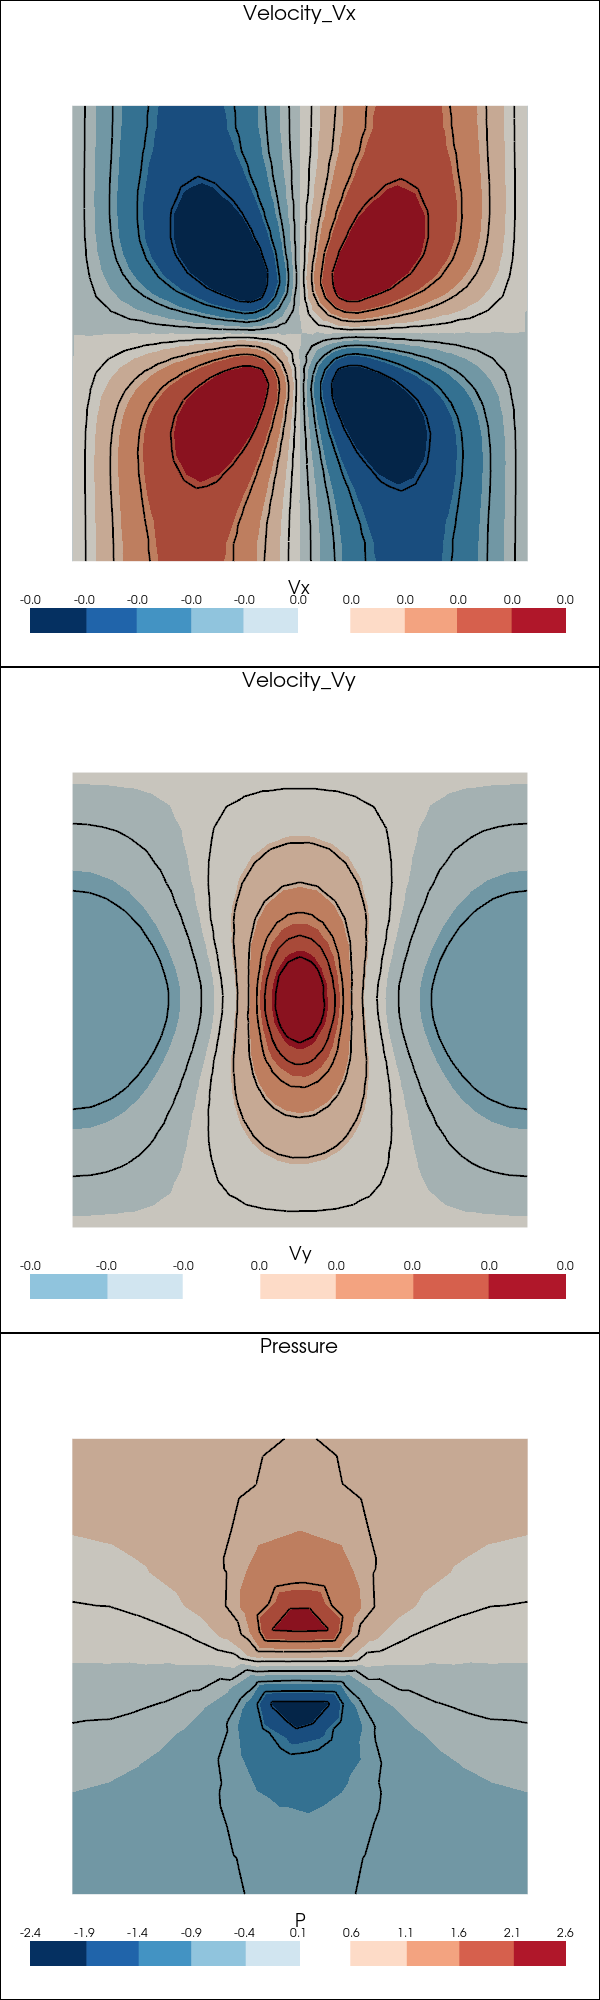

In [20]:
par = parameters()
par.dgrav = 50. # adjust it and record the maximum velocties

background_viscosity = 5000000# change this number
par.eta_crust, par.eta_mantle, par.eta_inc = background_viscosity, background_viscosity, 5000000. # make background viscosities homogeneous and use strong sphere

runScenarioPlot(par, plotStyle='scalar')

The velocity is proportional to the viscosity and the densities. Whenever the velocity of the substance increases, the viscosity is usually lower  and the densities of the ball will usually be lower than the densities of the liquids. 

Whenever comparing what different values of viscosity and densities do to the other values such as velocity, we can see that the velocity is a lot larger indicated by darker colors. This occurs whenever there is a higher viscosity. At some point if the viscosity is light compared to the densities of the spheres, the values can change and cause the ball to move up rather than down. Whenever we increase the viscocity by a large amount, the pull towards the sphere as shown on the plots is much grater, there is more resistance on the sphere. 

###  4b: Effect of distance of anomaly to boundary 

What if the sphere is moved up or down? What happens to velocities and pressures?

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.7
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  500.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 183 nodes
Info    : 364 elements
Info    : Done reading 'stokes.msh'
No normalization is needed.
No normalization is needed.
No normalization is needed.


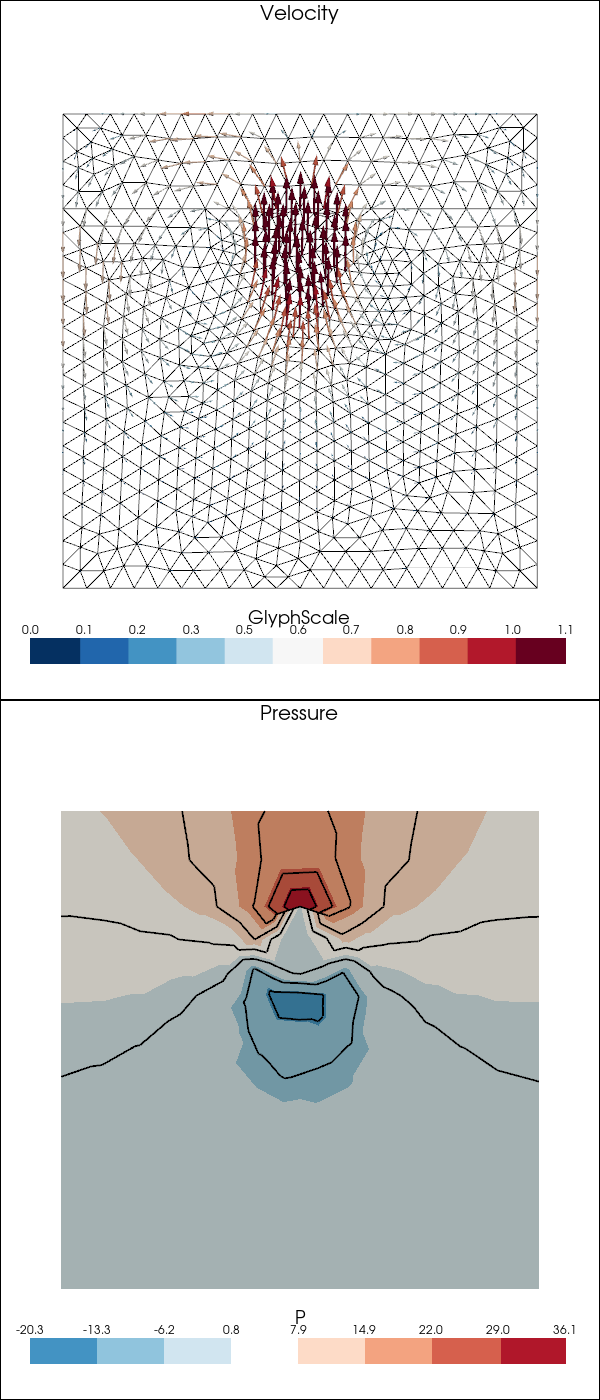

In [23]:
par = parameters()
par.ye = 0.7 # move the spheric anomaly up or down; please adjust it. NOTE, make sure the sphere is not out of bounds. The function modelGeometryCheck called by describeModel will verify it.
describeModel(par)
runScenarioPlot(par, plotStyle='vector')

Based on what we see, whenever we move the ball up there is more pressure build up at the top of the ball. This is similar to whenever we see a bcs type 2 example, where the top of the ball also has higher pressure than the bottom, causing uplift in the surface. The only problem is that this example is not bcs type 2 so there should be restrictions on the top of the ball. For the velocity we also see that it also increases at the surface of the ball because the movement is furthur up than in the middle.  

### 4c: What if the model domain is enlarged 3 times? Or 5 or 10 times?  

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.6 2.4  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 1.5 1.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  500.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 1381 nodes
Info    : 2760 elements
Info    : Done reading 'stokes.msh'
No normalization is needed.
No normalization is needed.
No normalization is needed.


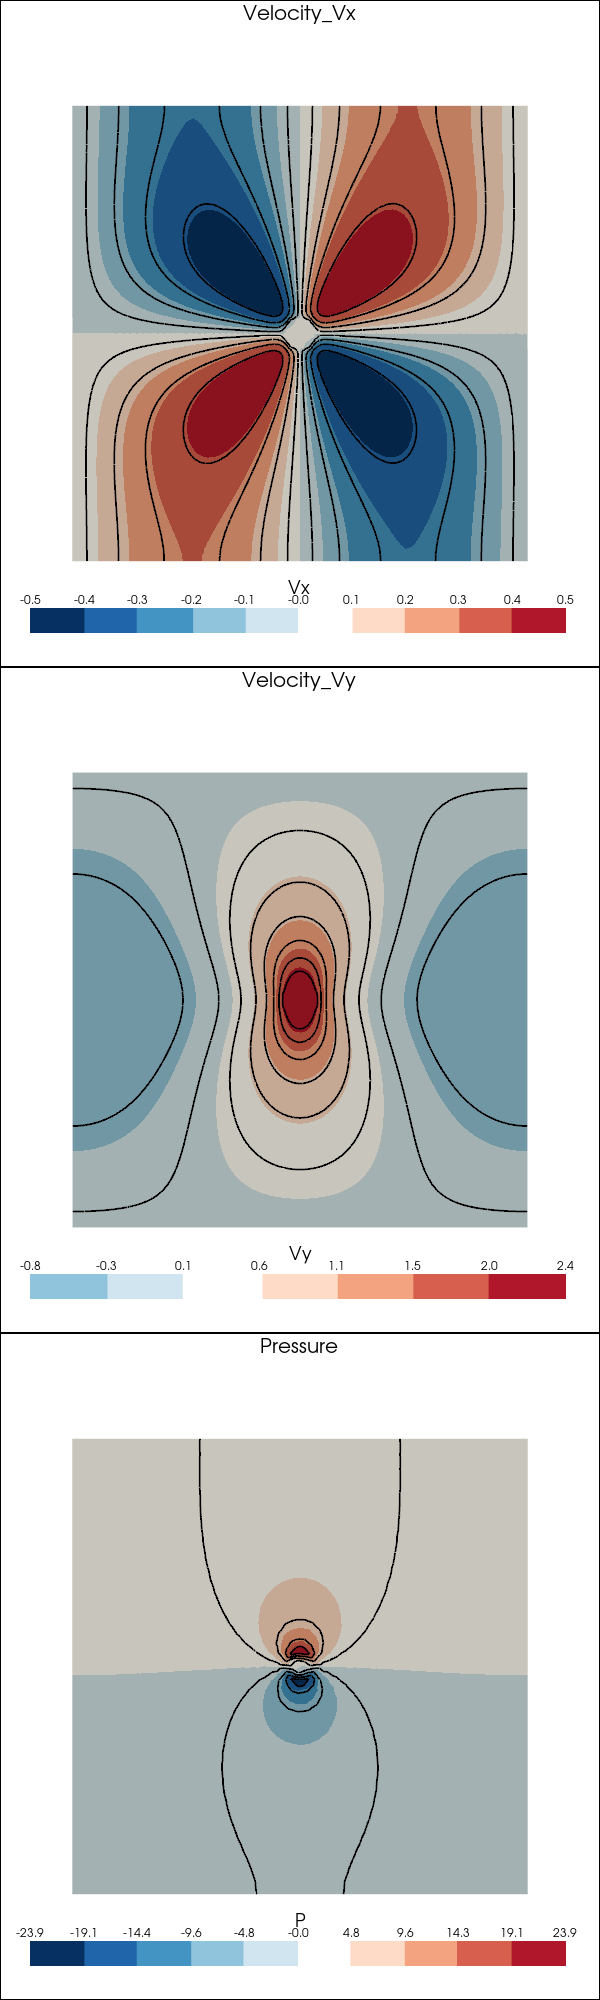

In [24]:
par = parameters()
par.w, par.h_crust, par.h_mantle = 3, 0.6, 2.4
par.xe, par.ye = 1.5, 1.5
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

Whenever the model is increased by a large amount we see that the pressure as it moves away from the ball is minimal, and whenever it is close to the ball it is very high or very low based on the position the top or bottom. We see that the velocity is increased significantly signifying a speed up in the ascend of the ball. There is more liquid around the ball that is being affected because of the faster velocity. 

## Experiment 5: the effect of the anomaly viscosity contrast
Now we explore how maximum (or mean) velocities (where) as a function of viscosity contrast of the ellipse and surrounding mantle. 

Could you change the viscosity of eta_inc to 10,000, 100, 1, 0.01, 0.00001, and record maximum velocities and plot them against eta_inc? Note that the default eta_crust and eta_mantle are 1, and eta_inc of the anomaly is the same as the viscosity contrast. 

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 0.8  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.1 0.1  is inserted and its center is located at 0.5 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1e-05  respectively.
The gravity anomaly for the ellipse is  500.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 185 nodes
Info    : 368 elements
Info    : Done reading 'stokes.msh'
No normalization is needed.
No normalization is needed.
No normalization is needed.


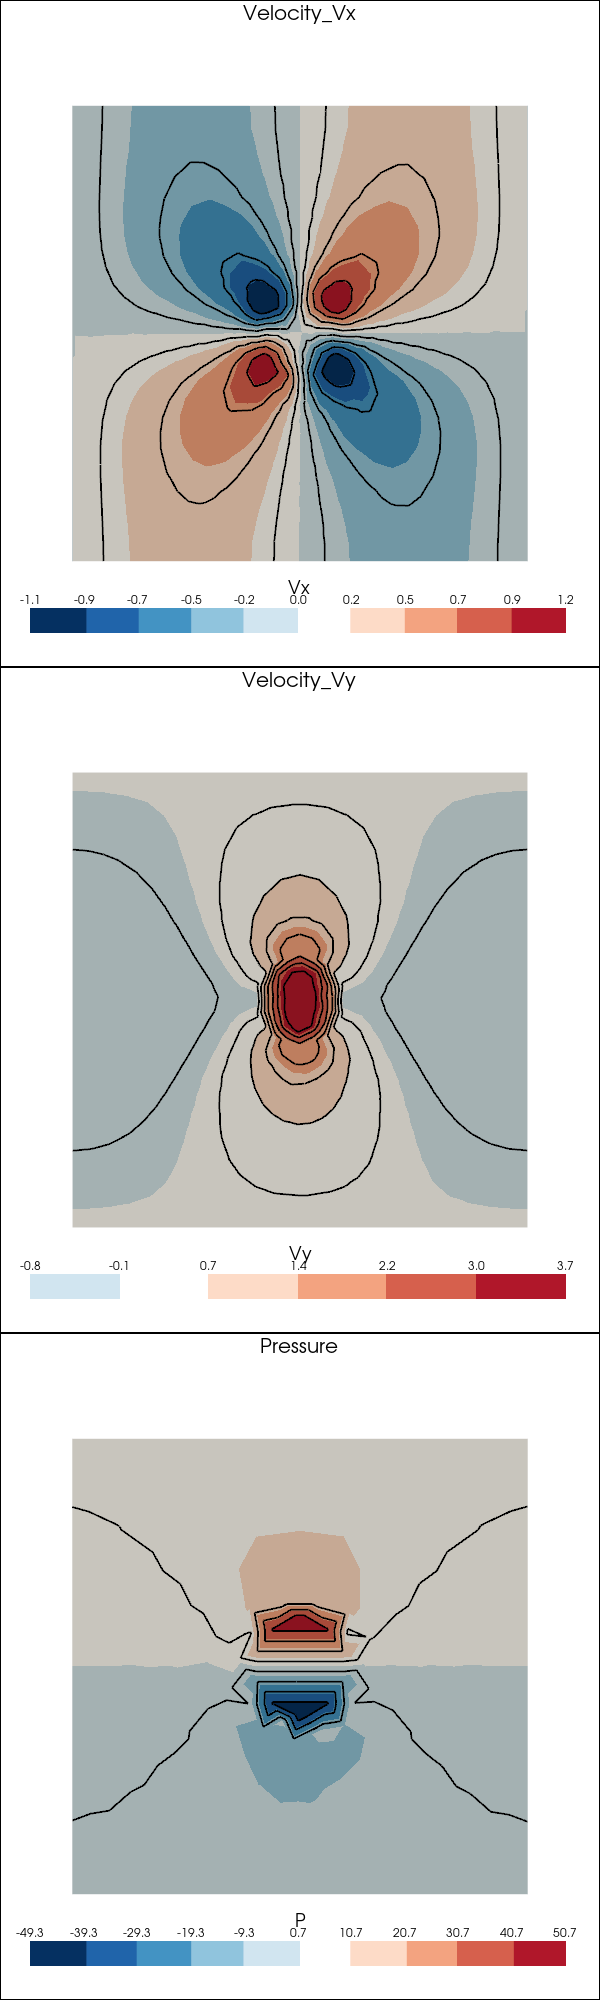

In [30]:
par = parameters()
par.eta_inc = .00001 # please adjust it for different viscosity contrast
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

Viscosity:10000, 100, 1, 0.01, 0.00001
Max Velocities: 1.2, 1.2, 1.7, 3.6, 3.7

For these maxes I used the Vy velocities. From this information we see that the larger the viscosity we use, the lower our velocities and as our values for the viscosity increases, the velocities increase at a similar rate. 

## Experiment 6: the effect of ellipticity and orientations of the anomaly.

Let's change the spheric anomaly to an ellipse of 0.5 by 0.05, and also rotate the ellipse, to see how the velocities and pressures change. 

Model description.
A 2-D block that has two horizontal layers.
The thicknesses of the crust and mantle are  0.2 1.5  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.4 0.1  is inserted and its center is located at 0.75 0.75
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 1000.0  respectively.
The gravity anomaly for the ellipse is  500.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 431 nodes
Info    : 860 elements
Info    : Done reading 'stokes.msh'
No normalization is needed.
No normalization is needed.
No normalization is needed.


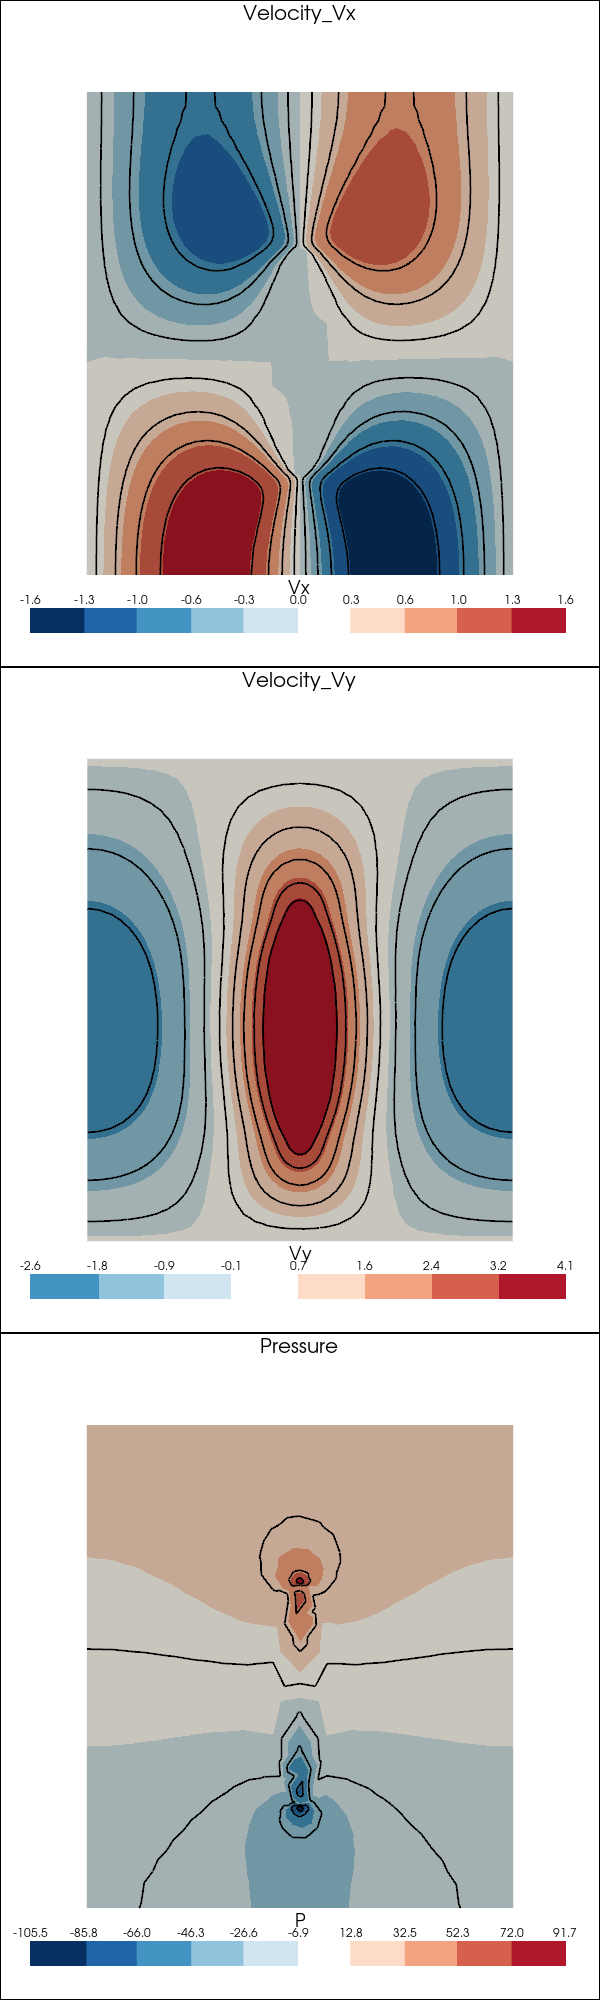

In [33]:
par = parameters()
par.w, par.h_mantle = 1.5, 1.5
par.dxx = 0.1
par.xe, par.ye = par.w/2, par.h_mantle/2
par.ra, par.rb, par.rot = 0.4, 0.1, 0.5*pi
describeModel(par)
runScenarioPlot(par, plotStyle='scalar')

Based on different values of the ellipse, we can see that depending on the size of the shape it will break and can break the symmetry of the velocity values and pressures. Whenever we make the value .5 into .005 the liquid moves around the shape in an irregular shape than that of a sphere, furthurmore, becasue of this and the size of the ellipse it will change the way a liquid flows around it and cause different movement.